# MVO

In [2]:
import pandas as pd
import numpy as np
import scipy.optimize
from scipy.optimize import minimize
import warnings
import pylab
from datetime import datetime
from pypfopt import plotting
# iFinDPy 试用权限只支持最近5年的历史行情
import akshare as ak 
#https://akshare.xyz/data/index.html 
#https://akshare.xyz/tutorial.html#id1

In [51]:
def report_Q(date):
    current_date=datetime.strptime(date, '%Y%m%d')
    if current_date.month in [1, 2, 3] or (current_date.month == 3 and current_date.day <= 30):
        res = 4
    elif current_date.month in [4, 5, 6] or (current_date.month == 6 and current_date.day <= 29):
        res = 1
    elif current_date.month in [7, 8, 9] or (current_date.month == 9 and current_date.day <= 29):
        res = 2
    else:
        res = 3
    return res
index_stock=pd.read_excel('C:/Users/HP/Desktop/index.xlsx',sheet_name=0)
index_stock

pitch = pd.DataFrame()
for i in range(len(index_stock['code'])): 
    pitch = index_stock['code'][i] + index_stock['指数名称'][i] 
pitch

'930715朝阳88（分析师预期）'

In [21]:
import os
file_path = 'C:/Users/HP/Desktop/index.xlsx'  # Replace with the path to your Excel file
# Check if the file exists
if os.path.exists(file_path):
    os.system(f'start excel "{file_path}"')
else:
    print(f"The Excel file '{file_path}' does not exist.")

# ! Datasource

In [4]:
today = datetime.today().strftime("%Y-%m-%d") # format '2023-09-08'
today = today.replace('-', '') # format'20230908'
Y=datetime.strptime(today, '%Y%m%d').year
report_Q(today) 

begin = '20120101'
# 1.portfolio = fund + bond + currency etc.
# 000300.SH[沪深300], 华夏智胜先锋股票(LOF)A[501219.SH], 中欧新动力混合(LOF)A[166009.SZ]
# 富国中债7-10年政策性金融债ETF[511520.SH]
#selection1 = ["sh501219","sz166009","sh000300"]
selection1 = ["sh501219","sh511520"] 

# 2.portfolio = equity1 + equity2 + equity3 etc.
selection2 = "501219" # fund code

In [28]:
import akshare as ak

index_zh_a_hist_df = ak.index_zh_a_hist(symbol="399317", period="daily", start_date=begin, end_date=today)
print(index_zh_a_hist_df)

index=100+11+46

              日期       开盘       收盘       最高       最低        成交量           成交额  \
0     2012-01-04  2340.47  2274.40  2346.32  2274.40   79986085  7.709268e+10   
1     2012-01-05  2263.75  2223.17  2273.82  2219.95   94095678  8.593097e+10   
2     2012-01-06  2217.84  2235.52  2235.52  2190.56   81248445  7.310273e+10   
3     2012-01-09  2235.49  2317.11  2317.31  2215.73  120140280  1.106732e+08   
4     2012-01-10  2315.42  2399.89  2401.38  2311.07  177297347  1.627718e+08   
...          ...      ...      ...      ...      ...        ...           ...   
2838  2023-09-06  5170.19  5191.63  5196.97  5152.10  621836301  7.468117e+11   
2839  2023-09-07  5180.71  5110.92  5180.71  5110.72  639968141  7.458946e+11   
2840  2023-09-08  5095.73  5105.35  5122.68  5082.20  553424127  6.605806e+11   
2841  2023-09-11  5109.85  5153.56  5175.75  5093.40  665038878  8.194576e+11   
2842  2023-09-12  5149.42  5155.01  5166.63  5138.63  470615327  5.809580e+11   

        振幅   涨跌幅    涨跌额  换手

-0.028229372732826996

In [32]:
stock_hk_index_daily_sina_df = ak.stock_hk_index_daily_sina(symbol="HSI")
print(stock_hk_index_daily_sina_df)

            date       open       high        low      close       volume
0     2013-08-20  22396.289  22481.740  21907.211  21964.051  63521943552
1     2013-08-21  21964.689  21970.250  21618.600  21817.730   7237451920
2     2013-08-22  21538.189  21944.471  21538.189  21895.400   8229202926
3     2013-08-23  22006.410  22103.900  21769.039  21863.510   7544465315
4     2013-08-26  21943.400  22116.000  21898.150  22005.320   7672641627
...          ...        ...        ...        ...        ...          ...
2472  2023-09-04  18592.530  18899.490  18575.450  18844.160  15819654229
2473  2023-09-05  18717.420  18725.500  18431.720  18456.910  10788726181
2474  2023-09-06  18405.090  18492.590  18256.100  18449.980  21638374919
2475  2023-09-07  18437.480  18437.480  18173.440  18202.070  16029034619
2476  2023-09-11  17941.650  18164.610  17842.370  18096.449  13068427373

[2477 rows x 6 columns]


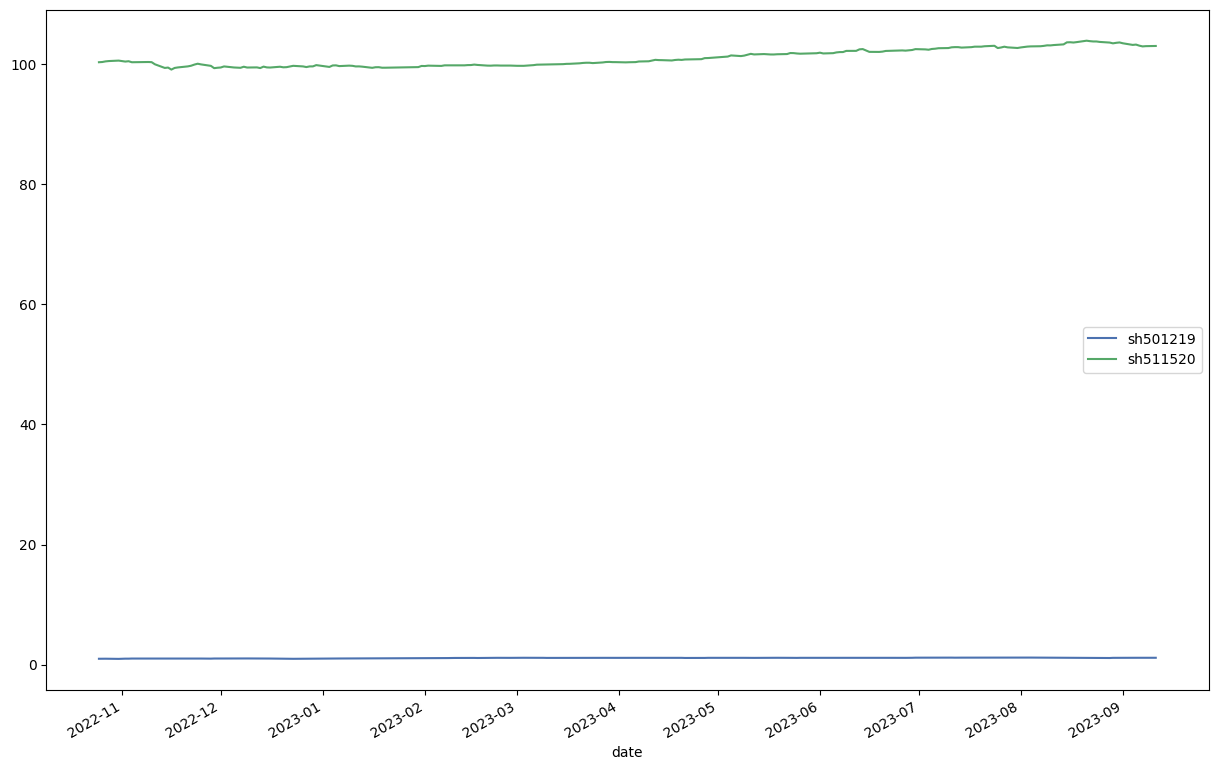

In [ ]:
# 1.portfolio = fund + bond + currency etc.
# 股票型基金收盘价 data_fund("sh501219", "20230101", "20230630")[['date']]
def data_fund(code, start, end):
    dataframe_fund = ak.stock_zh_index_daily_em(symbol = code, start_date = start, end_date = end)
    dataframe_fund.insert(0,column=code, value=dataframe_fund['close'])
    return dataframe_fund[['date',code]]
# 导入组合各基金收盘价
# port(["sh000300"], "20120101", "20230630")
# port(["sh000300","sh501219","sz166009"], "20120101", "20230630")
def port(code,start,end):
    res = data_fund(code[0],start,end)[['date']]
    for i in range(0,len(code)):
        dataframe = data_fund(code[i], start, end)
        res = pd.merge(res, dataframe, how='outer', on = 'date') 
    res.rename(columns={'date': 'datetime'}, inplace=True)
    res.insert(0,column='date', value=pd.to_datetime(res['datetime']))
    res.set_index('date', inplace=True)
    res=res.drop('datetime', axis=1)
    return res.dropna() 
# GFC后收盘价走势
def graph(port,datetime):
    port[port.index>= datetime].plot(figsize=(15,10));
    return pylab.show()
portfolio1=port(selection1, begin, today)
graph(portfolio1,"2008-01-01")

In [ ]:
portfolio1

,sh501219,sh511520
date,,
2022-10-25,0.988,100.320
2022-10-26,1.000,100.354
2022-10-27,0.997,100.458
2022-10-28,0.987,100.514
2022-10-31,0.969,100.589
...,...,...
2023-09-05,1.151,103.256
2023-09-06,1.153,103.079
2023-09-07,1.139,102.954


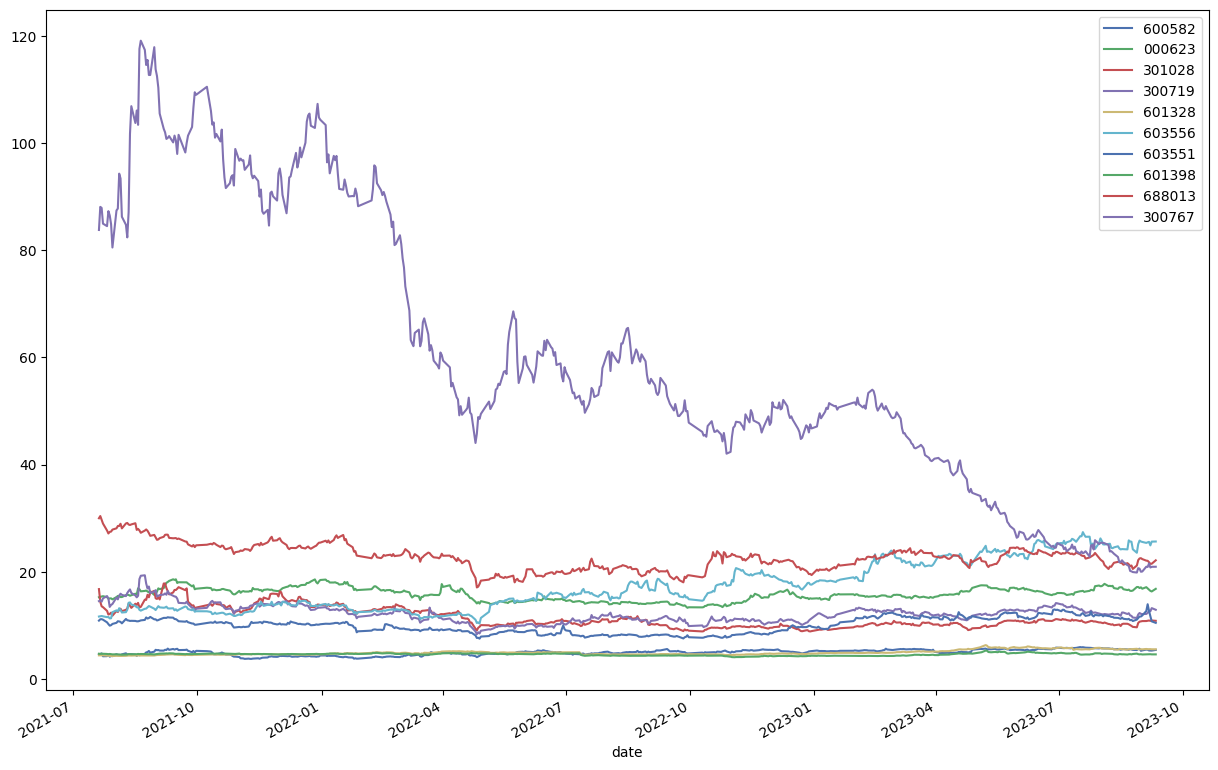

In [ ]:
# 2.portfolio = equity1 + equity2 + equity3 etc.
# 股票收盘价 data_equity("600129","20230401",today)
def data_equity(code, start, end):
    dataframe_equity = ak.stock_zh_a_hist(symbol=code, period="daily", start_date = start, end_date = end, adjust="")
    dataframe_equity.insert(0,column=code, value=dataframe_equity['收盘'])
    dataframe_equity.insert(0,column='date', value=dataframe_equity['日期'])
    return dataframe_equity[['date',code]]
# 基金各股票 all_stock("501219","20230301","20230907",2023,1)
def all_stock(fund_code,start,end,year,Q):
    warnings.simplefilter(action='ignore', category=FutureWarning)
    all=ak.fund_portfolio_hold_em(symbol=fund_code, date=year)
    all=all.loc[all['季度'] == str(year)+'年'+str(Q)+'季度股票投资明细']
    all.insert(0,column=fund_code, value=all['股票代码'])
    return all[[fund_code]]
# 前十重仓股票收盘价 portfolio_stock("501219","20170301","20210907",2023,2,10)
def portfolio_stock(fund_code,start,end,year,Q,top_stock):
    stock_list = all_stock(fund_code,start,end,year,Q)
    res = data_equity(stock_list[fund_code][0],start,end)[['date']]
    for i in range(0,top_stock):
        dataframe=pd.DataFrame()
        dataframe = data_equity(stock_list[fund_code][i], start, end)
        res = pd.merge(res, dataframe, how='outer', on = 'date') 
    res.rename(columns={'date': 'datetime'}, inplace=True)
    res.insert(0,column='date', value=pd.to_datetime(res['datetime']))
    res.set_index('date', inplace=True)
    res=res.drop('datetime', axis=1)
    return res.dropna()
# GFC后收盘价走势
portfolio2=portfolio_stock(selection2,begin,today,Y,report_Q(today),10)
def graph(portfolio,datetime):
    portfolio[portfolio.index>= datetime].plot(figsize=(15,10));
    return pylab.show()
graph(portfolio2,"2008-01-01")

In [ ]:
portfolio2

,600582,000623,301028,300719,601328,603556,603551,601398,688013,300767
date,,,,,,,,,,
2021-07-20,4.57,15.25,16.77,14.53,4.41,11.65,10.89,4.71,29.99,83.78
2021-07-21,4.65,15.31,14.40,14.69,4.41,11.69,11.14,4.69,30.40,88.09
2021-07-22,4.77,15.38,13.56,14.42,4.41,11.75,11.16,4.71,29.69,87.90
2021-07-23,4.24,15.45,13.40,15.04,4.41,11.69,11.06,4.70,29.00,84.96
2021-07-26,4.26,15.26,12.71,15.47,4.35,11.54,10.57,4.67,27.70,84.50
...,...,...,...,...,...,...,...,...,...,...
2023-09-05,5.46,16.90,10.87,12.32,5.55,25.50,13.95,4.59,22.05,20.90
2023-09-06,5.32,16.67,10.91,12.75,5.56,25.58,12.70,4.61,21.79,21.55
2023-09-07,5.31,16.44,10.84,12.63,5.57,24.93,11.72,4.62,21.48,20.80


# ! Portfolio

In [ ]:
portfolio=portfolio1

# Calculation  

returns

In [ ]:
def table(portfolio,frequency=252):
    total_return=portfolio.iloc[-1, :] / portfolio.iloc[0, :]
    period=(portfolio.index[-1] - portfolio.index[0]).days/365
    mean=total_return**(1 / period) - 1
    std=(portfolio.pct_change()[1:].std())*np.sqrt(frequency)
    res = pd.DataFrame({"mean":mean,"std": std})
    return res
table(portfolio)

,mean,std
sh501219,0.190797,0.119121
sh511520,0.030727,0.018754


annual returns

In [ ]:
def returns(portfolio,frequency=252):
    total_return=portfolio.iloc[-1, :] / portfolio.iloc[0, :]
    period=(portfolio.index[-1] - portfolio.index[0]).days/365
    mean=total_return**(1 / period) - 1
    std=(portfolio.pct_change()[1:].std())*np.sqrt(frequency)
    res = pd.DataFrame({"mean":mean,"std": std})
    return np.array(mean)
returns(portfolio)

array([0.19079664, 0.03072728])

covariance

In [ ]:
# calculating the covariance matrix
def covariance(portfolio,frequency=252):
    res = portfolio.pct_change().dropna(how="all").cov()*frequency
    return res 
covariance(portfolio)


,sh501219,sh511520
sh501219,0.014190,-0.000685
sh511520,-0.000685,0.000352


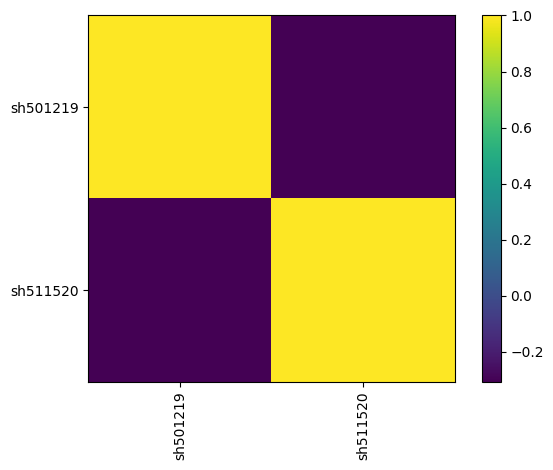

In [ ]:
plotting.plot_covariance(covariance(portfolio1), plot_correlation=True);
# pylab.show()

max return

In [ ]:
def optimization(returns,cov_matrix,way="max_ret",target=0.1,w1=0.4,w2=0.5):
    n = len(returns) # Total number of assets
    weights = np.ones(n) / n # Initial guess for weights
    bounds = [(0, 1) for _ in range(n)] # Set bounds for weights (between 0 and 1)    
    def asset1_constraint(weights):
        return w1 - weights[0]  # Constraint for asset 1: 0 <= Weight <= w1
    def asset2_constraint(weights):
        return w2 - weights[1]  # Constraint for asset 2: 0 <= Weight <= w2
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Full investment constraint
        {'type': 'ineq', 'fun': asset1_constraint},  # Constraint for asset 1
        {'type': 'ineq', 'fun': asset2_constraint}]  # Constraint for asset 2
    
    if way == "max_ret":
        def objective_function(weights, returns): # maximize (portfolio return)
            return -np.sum(returns * weights)  # maximize the negative return
        def risk_constraint(weights, cov_matrix):
            portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            return target - portfolio_volatility  # Constraint: Standard Deviation <= 10%
        constraints = constraints + [{'type': 'ineq', 'fun': risk_constraint, 'args': (cov_matrix,)}]
        result = minimize(objective_function, weights, args=(returns,), method='SLSQP', constraints=constraints, bounds=bounds)
        SD=np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x)))
        return "Optimal Portfolio Weights:"+str(result.x)+". Optimal Portfolio Return:"+str(-result.fun)+". Optimal Portfolio Standard Deviation:"+str(SD)
    elif way == "min_std":
        def objective_function(weights, cov_matrix):
            portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
            return portfolio_variance  # We minimize portfolio variance
        def return_constraint(weights, returns, min_return):
            portfolio_return = np.sum(returns * weights)
            return portfolio_return - min_return  # Constraint: Expected Return >= min_return
        constraints = constraints + [{'type': 'ineq', 'fun': return_constraint, 'args': (returns, target)}]
        result = minimize(objective_function, weights, args=(cov_matrix,), method='SLSQP', constraints=constraints, bounds=bounds)
        return "Optimal Portfolio Weights:"+str(result.x)+". Optimal Portfolio Return:"+str(np.sum(returns * result.x))+". Optimal Portfolio Variance:"+str(result.fun) 
optimization(returns(portfolio),covariance(portfolio))
        

'Optimal Portfolio Weights:[0.5 0.5]. Optimal Portfolio Return:0.11076196011593531. Optimal Portfolio Standard Deviation:0.05738487562303618'

min std

In [ ]:
optimization(returns(portfolio),covariance(portfolio),"min_std")

'Optimal Portfolio Weights:[0.5 0.5]. Optimal Portfolio Return:0.1107619600855292. Optimal Portfolio Variance:0.0032930239476427034'

# Tips

In [ ]:
variables = {}
for i in range(10):
    var_name = 'var' + str(i)  # 生成变量名
    var_value = i * 2  # 生成变量值
    variables[var_name] = var_value  # 将变量名和变量值添加到字典中

var0: 0
var1: 2
var2: 4
var3: 6
var4: 8
var5: 10
var6: 12
var7: 14
var8: 16
var9: 18

In [ ]:
iter_counter = 5 
for i in range(iter_counter): var_name = 'var' + str(i) 
# 生成变量名 var_value = i * 2 
# # 生成变量值 globals()[var_name] = var_value 
# # 使用globals()函数动态生成变量并赋值

# Economics

收入分配不均

存款利率-通货膨胀率
资产回报率、贷款利率
进口汇率

国有企业拥有土地、贷款、市场、优惠政策
垄断性质，在竞争性领域消失

自有+房贷 -> 利率 -> 资产回报率租金

# Alternative

In [ ]:
import pypfopt 
#https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html 
#https://github.com/robertmartin8/PyPortfolioOpt/tree/master/cookbook
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import mean_historical_return

# https://riskfolio-lib.readthedocs.io/en/latest/
#（json dig excel给客户看)

In [ ]:
ef = EfficientFrontier(returns(portfolio), risk_models.sample_cov(portfolio, frequency=252))
ef.min_volatility() #optimizes for minimum volatility

NameError: name 'returns' is not defined

In [ ]:
ef = EfficientFrontier(returns(portfolio), risk_models.sample_cov(portfolio, frequency=252))
ef.max_sharpe() #optimizes for maximal Sharpe ratio (a.k.a the tangency portfolio)

OrderedDict([('sh501219', 0.2002937182444747),
             ('sh511520', 0.7997062817555254)])

In [ ]:
ef = EfficientFrontier(returns(portfolio), risk_models.sample_cov(portfolio, frequency=252))
ef.efficient_risk(0.5) #maximises return for a given target risk

OrderedDict([('sh501219', 0.9999999997527592), ('sh511520', 2.475003e-10)])

In [ ]:
ef = EfficientFrontier(returns(portfolio), risk_models.sample_cov(portfolio, frequency=252))
ef.efficient_return(0.15) #minimises risk for a given target return